### **Automated Chest X-ray Report Generation Using Multimodal Deep Learning**

Medical practitioners routinely examine chest X-ray images and manually generate reports that include observations, findings, and diagnostic impressions. However, this manual process can be time-consuming and prone to delays, potentially impacting timely diagnosis and treatment. To address this challenge, this project aims to develop an automated radiology report generation system using a multimodal deep learning approach based on an encoder-decoder architecture.

For this task, we use the [Open-I Chest X-ray dataset](https://www.kaggle.com/datasets/raddar/chest-xrays-indiana-university/data) provided by Indiana University. The dataset contains 7,470 X-ray images and 3,851 corresponding patient reports, each comprising one or more images (1–5) captured in frontal and lateral views.

We designed and implemented a multimodal encoder-decoder framework that leverages a Vision Transformer (ViT) as the visual encoder and GPT-2 as the language decoder. A cross-attention mechanism was incorporated to align visual features with the corresponding textual content. To explore architectural variations, we also experimented with the Swin Transformer as an alternative encoder and the model’s performance was evaluated using standard NLP metrics, including BLEU and ROUGE-L.

In [ ]:
!pip install nltk
!pip install rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=c64d05023b03add82def8007f94bff95d5755803d7fb100cecb2c251dc11fdbd
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [ ]:
import os
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import tqdm.auto as tqdm
import torch.optim as optim
from PIL import Image
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from transformers import (
    GPT2Tokenizer,
    GPT2LMHeadModel,
    ViTModel,
    ViTFeatureExtractor
)
from transformers import ViTImageProcessor
from transformers import ViTModel, GPT2LMHeadModel
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm
from sklearn.model_selection import train_test_split

from nltk.tokenize import word_tokenize
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer

from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.tokenize import word_tokenize
from rouge_score import rouge_scorer

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
img_base_dir = '/kaggle/input/chest-xrays-indiana-university/images/images_normalized'
reports_df = pd.read_csv('/kaggle/input/chest-xrays-indiana-university/indiana_reports.csv')
projections_df = pd.read_csv('/kaggle/input/chest-xrays-indiana-university/indiana_projections.csv')

In [ ]:
reports_df.head()

,uid,MeSH,Problems,image,indication,comparison,findings,impression
0,1,normal,normal,Xray Chest PA and Lateral,Positive TB test,None.,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.
1,2,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",Preop bariatric surgery.,None.,Borderline cardiomegaly. Midline sternotomy XX...,No acute pulmonary findings.
2,3,normal,normal,Xray Chest PA and Lateral,"rib pain after a XXXX, XXXX XXXX steps this XX...",NaN,NaN,"No displaced rib fractures, pneumothorax, or p..."
3,4,"Pulmonary Disease, Chronic Obstructive;Bullous...","Pulmonary Disease, Chronic Obstructive;Bullous...","PA and lateral views of the chest XXXX, XXXX a...",XXXX-year-old XXXX with XXXX.,None available,There are diffuse bilateral interstitial and a...,1. Bullous emphysema and interstitial fibrosis...
4,5,Osteophyte/thoracic vertebrae/multiple/small;T...,Osteophyte;Thickening;Lung,Xray Chest PA and Lateral,Chest and nasal congestion.,NaN,The cardiomediastinal silhouette and pulmonary...,No acute cardiopulmonary abnormality.


In [ ]:
reports_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3851 entries, 0 to 3850
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   uid         3851 non-null   int64 
 1   MeSH        3851 non-null   object
 2   Problems    3851 non-null   object
 3   image       3851 non-null   object
 4   indication  3765 non-null   object
 5   comparison  2685 non-null   object
 6   findings    3337 non-null   object
 7   impression  3820 non-null   object
dtypes: int64(1), object(7)
memory usage: 240.8+ KB


In [ ]:
projections_df.head()

,uid,filename,projection
0,1,1_IM-0001-4001.dcm.png,Frontal
1,1,1_IM-0001-3001.dcm.png,Lateral
2,2,2_IM-0652-1001.dcm.png,Frontal
3,2,2_IM-0652-2001.dcm.png,Lateral
4,3,3_IM-1384-1001.dcm.png,Frontal


In [ ]:
projections_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7466 entries, 0 to 7465
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   uid         7466 non-null   int64 
 1   filename    7466 non-null   object
 2   projection  7466 non-null   object
dtypes: int64(1), object(2)
memory usage: 175.1+ KB


In [ ]:
reports_df = reports_df.dropna(subset=["findings"]).set_index("uid")
reports_df.head()

,MeSH,Problems,image,indication,comparison,findings,impression
uid,,,,,,,
1,normal,normal,Xray Chest PA and Lateral,Positive TB test,None.,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.
2,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",Preop bariatric surgery.,None.,Borderline cardiomegaly. Midline sternotomy XX...,No acute pulmonary findings.
4,"Pulmonary Disease, Chronic Obstructive;Bullous...","Pulmonary Disease, Chronic Obstructive;Bullous...","PA and lateral views of the chest XXXX, XXXX a...",XXXX-year-old XXXX with XXXX.,None available,There are diffuse bilateral interstitial and a...,1. Bullous emphysema and interstitial fibrosis...
5,Osteophyte/thoracic vertebrae/multiple/small;T...,Osteophyte;Thickening;Lung,Xray Chest PA and Lateral,Chest and nasal congestion.,NaN,The cardiomediastinal silhouette and pulmonary...,No acute cardiopulmonary abnormality.
6,normal,normal,"PA and Lateral Chest. XXXX, XXXX at XXXX",Evaluate for infection,"XXXX, XXXX",Heart size and mediastinal contour are within ...,No acute cardiopulmonary findings.


In [ ]:
projections_df = projections_df.set_index("uid")
projections_df.head()

,filename,projection
uid,,
1,1_IM-0001-4001.dcm.png,Frontal
1,1_IM-0001-3001.dcm.png,Lateral
2,2_IM-0652-1001.dcm.png,Frontal
2,2_IM-0652-2001.dcm.png,Lateral
3,3_IM-1384-1001.dcm.png,Frontal


### Encoder: **Vision Transformer (ViT)** + Decoder: **GPT-2**

In [ ]:
uids = list(set(reports_df.index).intersection(projections_df.index))

In [ ]:
train_uids, test_uids = train_test_split(uids, test_size=0.1, random_state=42)

In [ ]:
vit_processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [ ]:
class ImageCaptionData(Dataset):
    def __init__(self, reports_df, projections_df, uids, img_base_dir, max_length=128):
        self.reports_df = reports_df
        self.projections_df = projections_df
        self.uids = uids
        self.img_base_dir = img_base_dir
        self.max_length = max_length

    def __getitem__(self, index):
        uid = self.uids[index]

        # Load and preprocess image
        image_paths = [os.path.join(self.img_base_dir, x) for x in self.projections_df.loc[[uid]]["filename"]]
        images = torch.stack([
            vit_processor(images=Image.open(img).convert("RGB"), return_tensors="pt")["pixel_values"].squeeze(0)
            for img in image_paths
        ])
        img_embed = images.mean(dim=0)  # Average over multiple images per report

        # Process text (tokenization)
        findings = tokenizer.encode(self.reports_df.loc[uid]["findings"])
        findings = torch.tensor(findings[:self.max_length-1] + [tokenizer.eos_token_id])
        attn_mask = (findings != tokenizer.pad_token_id).long()

        return img_embed, findings, attn_mask

    def __len__(self):
        return len(self.uids)


def collate_batch(batch):
    img_data = torch.stack([item[0] for item in batch])
    tokens = pad_sequence([item[1] for item in batch], batch_first=True, padding_value=tokenizer.pad_token_id)
    attn_mask = pad_sequence([item[2] for item in batch], batch_first=True, padding_value=0)
    labels = tokens.clone()
    return img_data, tokens, labels, attn_mask

In [ ]:
train_dataset = ImageCaptionData(reports_df, projections_df, train_uids, img_base_dir)
test_dataset = ImageCaptionData(reports_df, projections_df, test_uids, img_base_dir)
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=collate_batch)

In [ ]:
import torch.nn as nn

class CrossAttention(nn.Module):
    def __init__(self, embed_dim=768, num_heads=8):
        super(CrossAttention, self).__init__()
        self.multihead_attn = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, img_features, text_embeds):
        attn_output, _ = self.multihead_attn(text_embeds, img_features, img_features)
        attn_output = self.norm(attn_output + text_embeds)  # Residual Connection
        return attn_output


In [ ]:
vit_model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k").to(device)
vit_model.eval()

gpt2_model = GPT2LMHeadModel.from_pretrained("gpt2").to(device)
cross_attention = CrossAttention(embed_dim=768).to(device)

for param in vit_model.parameters():
    param.requires_grad = False

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
# Define optimizer and model save path
optimizer = optim.AdamW(
    list(gpt2_model.parameters()) + list(cross_attention.parameters()), lr=5e-5
)
MODEL_SAVE_PATH = "/kaggle/working/Vit_GPT2_IUXray"
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

# Training parameters
NUM_EPOCHS = 10
best_val_loss = float("inf")
patience = 3  # Number of epochs to wait for improvement before early stopping
early_stopping_counter = 0

# Smoothing function for BLEU to avoid zero scores
smooth_fn = SmoothingFunction().method1

for epoch in range(1, NUM_EPOCHS + 1):
    gpt2_model.train()
    cross_attention.train()
    train_losses = []

    # --- Training Phase ---
    for img, tokens, labels, attn_mask in tqdm(train_dataloader, desc=f"Training Epoch {epoch}"):
        img, tokens, labels, attn_mask = (
            img.to(device), tokens.to(device), labels.to(device), attn_mask.to(device)
        )
        optimizer.zero_grad()

        # Get image features from ViT
        img_embed = vit_model(pixel_values=img).last_hidden_state[:, 0, :]
        # Get GPT-2 token embeddings
        tok_embed = gpt2_model.get_input_embeddings()(tokens)
        # Fuse via cross-attention
        attn_output = cross_attention(img_embed.unsqueeze(1).expand(-1, tok_embed.shape[1], -1), tok_embed)

        # Forward pass through GPT-2
        outputs = gpt2_model(inputs_embeds=attn_output, labels=labels, attention_mask=attn_mask)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    avg_train_loss = np.mean(train_losses)

    # --- Validation Phase ---
    gpt2_model.eval()
    cross_attention.eval()
    val_losses = []
    bleu1_scores, bleu2_scores, bleu3_scores, bleu4_scores = [], [], [], []
    rouge_scores = []
    rouge = rouge_scorer.RougeScorer(["rougeL"], use_stemmer=True)

    with torch.no_grad():
        for img, tokens, labels, attn_mask in tqdm(test_dataloader, desc=f"Validating Epoch {epoch}"):
            img, tokens, labels, attn_mask = (
                img.to(device), tokens.to(device), labels.to(device), attn_mask.to(device)
            )

            img_embed = vit_model(pixel_values=img).last_hidden_state[:, 0, :]
            tok_embed = gpt2_model.get_input_embeddings()(tokens)
            attn_output = cross_attention(img_embed.unsqueeze(1).expand(-1, tok_embed.shape[1], -1), tok_embed)

            outputs = gpt2_model(inputs_embeds=attn_output, labels=labels, attention_mask=attn_mask)
            val_losses.append(outputs.loss.item())

            # Decode prediction and true label for BLEU & ROUGE evaluation
            pred_text = tokenizer.decode(torch.argmax(outputs.logits, dim=-1)[0].tolist(), skip_special_tokens=True)
            true_text = tokenizer.decode(labels[0][labels[0] != -100].tolist(), skip_special_tokens=True)

            # Tokenize texts
            ref_tokens = [word_tokenize(true_text)]
            pred_tokens = word_tokenize(pred_text)

            # Calculate BLEU scores with different weightings:
            bleu1 = sentence_bleu(ref_tokens, pred_tokens, weights=(1, 0, 0, 0), smoothing_function=smooth_fn)
            bleu2 = sentence_bleu(ref_tokens, pred_tokens, weights=(0.5, 0.5, 0, 0), smoothing_function=smooth_fn)
            bleu3 = sentence_bleu(ref_tokens, pred_tokens, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smooth_fn)
            bleu4 = sentence_bleu(ref_tokens, pred_tokens, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth_fn)

            bleu1_scores.append(bleu1)
            bleu2_scores.append(bleu2)
            bleu3_scores.append(bleu3)
            bleu4_scores.append(bleu4)

            # Calculate ROUGE-L score
            rouge_score = rouge.score(pred_text, true_text)["rougeL"].fmeasure
            rouge_scores.append(rouge_score)

    avg_val_loss = np.mean(val_losses) if val_losses else float("inf")
    avg_bleu1 = np.mean(bleu1_scores) if bleu1_scores else 0
    avg_bleu2 = np.mean(bleu2_scores) if bleu2_scores else 0
    avg_bleu3 = np.mean(bleu3_scores) if bleu3_scores else 0
    avg_bleu4 = np.mean(bleu4_scores) if bleu4_scores else 0
    avg_rouge = np.mean(rouge_scores) if rouge_scores else 0

    output_msg = (
        f"\n=== Epoch {epoch}/{NUM_EPOCHS} ===\n"
        f"Train Loss: {avg_train_loss:.4f}\n"
        f"Validation Loss: {avg_val_loss:.4f}\n"
        f"BLEU-1: {avg_bleu1:.4f}\n"
        f"BLEU-2: {avg_bleu2:.4f}\n"
        f"BLEU-3: {avg_bleu3:.4f}\n"
        f"BLEU-4: {avg_bleu4:.4f}\n"
        f"ROUGE-L Score: {avg_rouge:.4f}\n"
    )
    print(output_msg)

    # Early stopping and model saving
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stopping_counter = 0  # Reset counter on improvement
        print(f" Best Model Found! Saving with Val Loss: {best_val_loss:.4f}")

        gpt2_model.save_pretrained(os.path.join(MODEL_SAVE_PATH, "ViT_gpt2"))
        tokenizer.save_pretrained(os.path.join(MODEL_SAVE_PATH, "ViT_gpt2_tokenizer"))
        torch.save(vit_model.state_dict(), os.path.join(MODEL_SAVE_PATH, "ViT_model.pth"))
        torch.save(cross_attention.state_dict(), os.path.join(MODEL_SAVE_PATH, "CrossAttention.pth"))
        print(f" Model saved successfully at {MODEL_SAVE_PATH}")
    else:
        early_stopping_counter += 1
        print(f"Early Stopping Counter: {early_stopping_counter}/{patience}")

    if early_stopping_counter >= patience:
        print("Early stopping triggered. Training stopped.")
        break


Validating Epoch 1: 100%|██████████| 84/84 [01:32<00:00,  1.10s/it]



=== Epoch 1/10 ===
Train Loss: 1.3087
Validation Loss: 0.9182
BLEU-1: 0.6508
BLEU-2: 0.5387
BLEU-3: 0.4530
BLEU-4: 0.3743
ROUGE-L Score: 0.6194

 Best Model Found! Saving with Val Loss: 0.9182
 Model saved successfully at /kaggle/working/Vit_GPT2_IUXray


Validating Epoch 2: 100%|██████████| 84/84 [01:18<00:00,  1.07it/s]



=== Epoch 2/10 ===
Train Loss: 0.8552
Validation Loss: 0.8133
BLEU-1: 0.6910
BLEU-2: 0.5883
BLEU-3: 0.5123
BLEU-4: 0.4456
ROUGE-L Score: 0.6590

 Best Model Found! Saving with Val Loss: 0.8133
 Model saved successfully at /kaggle/working/Vit_GPT2_IUXray


Validating Epoch 3: 100%|██████████| 84/84 [01:16<00:00,  1.10it/s]



=== Epoch 3/10 ===
Train Loss: 0.7363
Validation Loss: 0.7685
BLEU-1: 0.6955
BLEU-2: 0.6003
BLEU-3: 0.5295
BLEU-4: 0.4724
ROUGE-L Score: 0.6744

 Best Model Found! Saving with Val Loss: 0.7685
 Model saved successfully at /kaggle/working/Vit_GPT2_IUXray


Validating Epoch 4: 100%|██████████| 84/84 [01:17<00:00,  1.08it/s]



=== Epoch 4/10 ===
Train Loss: 0.6563
Validation Loss: 0.7430
BLEU-1: 0.7045
BLEU-2: 0.6154
BLEU-3: 0.5475
BLEU-4: 0.4887
ROUGE-L Score: 0.6841

 Best Model Found! Saving with Val Loss: 0.7430
 Model saved successfully at /kaggle/working/Vit_GPT2_IUXray


Validating Epoch 5: 100%|██████████| 84/84 [01:17<00:00,  1.08it/s]



=== Epoch 5/10 ===
Train Loss: 0.5920
Validation Loss: 0.7250
BLEU-1: 0.7064
BLEU-2: 0.6164
BLEU-3: 0.5459
BLEU-4: 0.4899
ROUGE-L Score: 0.6864

 Best Model Found! Saving with Val Loss: 0.7250
 Model saved successfully at /kaggle/working/Vit_GPT2_IUXray


Validating Epoch 6: 100%|██████████| 84/84 [01:16<00:00,  1.09it/s]



=== Epoch 6/10 ===
Train Loss: 0.5411
Validation Loss: 0.7235
BLEU-1: 0.7221
BLEU-2: 0.6319
BLEU-3: 0.5631
BLEU-4: 0.5052
ROUGE-L Score: 0.6976

 Best Model Found! Saving with Val Loss: 0.7235
 Model saved successfully at /kaggle/working/Vit_GPT2_IUXray


Validating Epoch 7: 100%|██████████| 84/84 [01:16<00:00,  1.10it/s]



=== Epoch 7/10 ===
Train Loss: 0.4883
Validation Loss: 0.7447
BLEU-1: 0.7124
BLEU-2: 0.6219
BLEU-3: 0.5504
BLEU-4: 0.4893
ROUGE-L Score: 0.6944

Early Stopping Counter: 1/3


Validating Epoch 8: 100%|██████████| 84/84 [01:18<00:00,  1.07it/s]



=== Epoch 8/10 ===
Train Loss: 0.4441
Validation Loss: 0.7455
BLEU-1: 0.7231
BLEU-2: 0.6369
BLEU-3: 0.5694
BLEU-4: 0.5119
ROUGE-L Score: 0.6954

Early Stopping Counter: 2/3


Validating Epoch 9: 100%|██████████| 84/84 [01:16<00:00,  1.09it/s]


=== Epoch 9/10 ===
Train Loss: 0.4076
Validation Loss: 0.7575
BLEU-1: 0.7134
BLEU-2: 0.6263
BLEU-3: 0.5553
BLEU-4: 0.4947
ROUGE-L Score: 0.6908

Early Stopping Counter: 3/3
Early stopping triggered. Training stopped.


### Inference:

In [ ]:
MODEL_SAVE_PATH = "/kaggle/working/Vit_GPT2_IUXray"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vit_model.load_state_dict(torch.load(os.path.join(MODEL_SAVE_PATH, "ViT_model.pth"), weights_only=True))
cross_attention.load_state_dict(torch.load(os.path.join(MODEL_SAVE_PATH, "CrossAttention.pth"), weights_only=True))
tokenizer = GPT2Tokenizer.from_pretrained(os.path.join(MODEL_SAVE_PATH, "ViT_gpt2_tokenizer"))
gpt2_model = GPT2LMHeadModel.from_pretrained(os.path.join(MODEL_SAVE_PATH, "ViT_gpt2")).to(device)
gpt2_model.eval()

vit_model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k").to(device)
vit_model.load_state_dict(torch.load(os.path.join(MODEL_SAVE_PATH, "ViT_model.pth"), weights_only=True))
vit_model.eval()

class CrossAttention(torch.nn.Module):
    def __init__(self, embed_dim=768, num_heads=8):
        super(CrossAttention, self).__init__()
        self.multihead_attn = torch.nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.norm = torch.nn.LayerNorm(embed_dim)

    def forward(self, img_features, text_embeds):
        attn_output, _ = self.multihead_attn(text_embeds, img_features, img_features)
        return self.norm(attn_output + text_embeds)

cross_attention = CrossAttention(embed_dim=768).to(device)
cross_attention.load_state_dict(torch.load(os.path.join(MODEL_SAVE_PATH, "CrossAttention.pth"), weights_only=True))
cross_attention.eval()

vit_processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

def process_xray(image_path):
    image = Image.open(image_path).convert("RGB")
    img_tensor = vit_processor(images=image, return_tensors="pt")["pixel_values"].to(device)
    return img_tensor

def generate_report(image_path, max_length=100):
    img_tensor = process_xray(image_path)
    with torch.no_grad():
        img_embed = vit_model(pixel_values=img_tensor).last_hidden_state
        img_embed = img_embed.mean(dim=1).unsqueeze(1)

    input_tokens = tokenizer.encode("Findings: ", return_tensors="pt").to(device)

    generated_text = ""
    for _ in range(max_length):
        with torch.no_grad():
            tok_embed = gpt2_model.get_input_embeddings()(input_tokens)
            attn_output = cross_attention(img_embed.expand(-1, tok_embed.shape[1], -1), tok_embed)
            outputs = gpt2_model(inputs_embeds=attn_output, past_key_values=None)
            next_token = torch.argmax(outputs.logits[:, -1, :], dim=-1)
            if next_token == tokenizer.eos_token_id:
                break
            input_tokens = torch.cat([input_tokens, next_token.unsqueeze(0)], dim=1)
            generated_text = tokenizer.decode(input_tokens[0], skip_special_tokens=True)

    return generated_text

image_path = "/kaggle/input/chest-xrays-indiana-university/images/images_normalized/1023_IM-0018-1001.dcm.png"

report = generate_report(image_path)
print(f"Generated Report: {report}")


Generated Report: Findings:  XXXX sternotomy XXXX and mediastinal clips are stable. There is no pneumothorax or pleural effusion. The heart is not significantly enlarged. There are atherosclerotic changes of the aorta. Arthritic changes of the skeletal structures are noted.


<ipython-input-49-ea6eccc56139>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vit_model.load_state_dict(torch.load(os.path.join(MODEL_SAVE_PATH, "ViT_model.pth"), map_lo

Common UIDs: {1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 22, 23, 24, 25, 26, 27, 28, 30, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 62, 63, 64, 65, 66, 67, 69, 70, 71, 72, 74, 75, 76, 79, 80, 81, 82, 84, 85, 86, 87, 88, 89, 90, 91, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 110, 112, 113, 114, 115, 116, 118, 119, 120, 121, 123, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 138, 139, 141, 142, 143, 144, 145, 147, 150, 151, 152, 153, 154, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 172, 173, 174, 175, 176, 177, 178, 179, 181, 182, 183, 184, 185, 186, 187, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 200, 201, 202, 203, 204, 206, 207, 208, 210, 211, 212, 215, 216, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 233, 234, 235, 236, 237, 238, 240, 241, 242, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257,

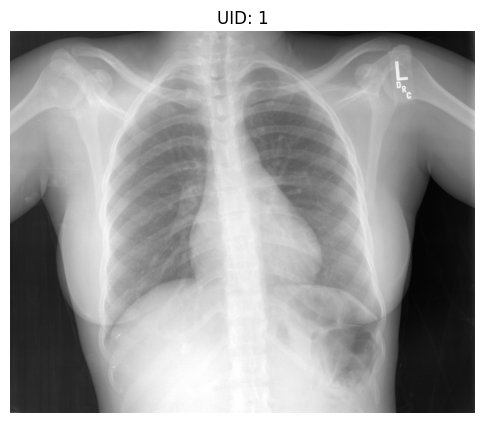

--------------------------------------------------
UID: 1
Real Finding:
The cardiac silhouette and mediastinum size are within normal limits. There is no pulmonary edema. There is no focal consolidation. There are no XXXX of a pleural effusion. There is no evidence of pneumothorax.
--------------------------------------------------
Predicted Report:
Findings:  XXXX sternotomy XXXX and mediastinal clips are stable. The lungs are clear. There is no pneumothorax or pleural effusion. The heart and mediastinum are normal. The skeletal structures are normal.
--------------------------------------------------
Evaluation Metrics:
BLEU-1: 0.4609
BLEU-2: 0.2698
BLEU-3: 0.1838
BLEU-4: 0.1133
ROUGE-L: 0.2154
--------------------------------------------------


In [ ]:
import os
import torch
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.tokenize import word_tokenize
from rouge_score import rouge_scorer
from transformers import ViTImageProcessor, ViTModel, GPT2LMHeadModel, GPT2Tokenizer

# ---------------------------
# Model and Tokenizer Loading
# ---------------------------
MODEL_SAVE_PATH = "/kaggle/working/Vit_GPT2_IUXray"  # Folder where models were saved

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load GPT-2 tokenizer and model from saved folder
tokenizer = GPT2Tokenizer.from_pretrained(os.path.join(MODEL_SAVE_PATH, "ViT_gpt2_tokenizer"))
tokenizer.pad_token = tokenizer.eos_token
gpt2_model = GPT2LMHeadModel.from_pretrained(os.path.join(MODEL_SAVE_PATH, "ViT_gpt2")).to(device)
gpt2_model.eval()

# Load ViT model from pretrained weights and then load saved state
vit_model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k").to(device)
vit_model.load_state_dict(torch.load(os.path.join(MODEL_SAVE_PATH, "ViT_model.pth"), map_location=device))
vit_model.eval()

# Define and load CrossAttention module
import torch.nn as nn
class CrossAttention(nn.Module):
    def __init__(self, embed_dim=768, num_heads=8):
        super(CrossAttention, self).__init__()
        self.multihead_attn = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.norm = nn.LayerNorm(embed_dim)
    def forward(self, img_features, text_embeds):
        attn_output, _ = self.multihead_attn(text_embeds, img_features, img_features)
        return self.norm(attn_output + text_embeds)

cross_attention = CrossAttention(embed_dim=768).to(device)
cross_attention.load_state_dict(torch.load(os.path.join(MODEL_SAVE_PATH, "CrossAttention.pth"), map_location=device))
cross_attention.eval()

# Load ViT feature extractor
vit_processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

# ---------------------------
# Load DataFrames (Reports and Projections)
# ---------------------------
# Load Indiana University reports
reports_df = pd.read_csv("/kaggle/input/chest-xrays-indiana-university/indiana_reports.csv")
reports_df = reports_df.dropna(subset=["findings"]).set_index("uid")

# Load projections which contain image filenames and projection type
projections_df = pd.read_csv("/kaggle/input/chest-xrays-indiana-university/indiana_projections.csv")
projections_df = projections_df.set_index("uid")

# Compute common UIDs between reports and projections
common_uids = set(reports_df.index).intersection(set(projections_df.index))
print("Common UIDs:", common_uids)

# ---------------------------
# Choose a Test UID and Image
# ---------------------------
# For example, choose the smallest UID (as integer) from the common set
test_uid = sorted(common_uids, key=lambda x: int(x))[0]
print("Selected UID:", test_uid)

# For the selected UID, choose the first image from projections_df
proj_entry = projections_df.loc[test_uid]
if isinstance(proj_entry, pd.DataFrame):
    image_name = proj_entry.iloc[0]["filename"]
else:
    image_name = proj_entry["filename"]

# Build the full image path (assuming images are stored in the Indiana University images folder)
image_path = os.path.join("/kaggle/input/chest-xrays-indiana-university/images/images_normalized", image_name)
print("Image Path:", image_path)

# ---------------------------
# Inference Functions
# ---------------------------
def process_xray(image_path):
    """Load and preprocess an image given its path."""
    image = Image.open(image_path).convert("RGB")
    img_tensor = vit_processor(images=image, return_tensors="pt")["pixel_values"].to(device)
    return img_tensor

def generate_report(image_path, max_length=100):
    """
    Generate a report from the image using ViT, GPT-2, and CrossAttention.
    Uses a starting prompt "Findings: " and autoregressively generates tokens.
    """
    img_tensor = process_xray(image_path)
    with torch.no_grad():
        # Extract image features from ViT and average over patches
        vit_outputs = vit_model(pixel_values=img_tensor)
        img_embed = vit_outputs.last_hidden_state.mean(dim=1).unsqueeze(1)  # shape: (1, 1, hidden_dim)

    # Initialize prompt
    input_tokens = tokenizer.encode("Findings: ", return_tensors="pt").to(device)

    # Generate tokens iteratively
    for _ in range(max_length):
        with torch.no_grad():
            tok_embed = gpt2_model.get_input_embeddings()(input_tokens)
            # Expand image embedding to match current sequence length
            fused_embeds = cross_attention(img_embed.expand(-1, tok_embed.shape[1], -1), tok_embed)
            outputs = gpt2_model(inputs_embeds=fused_embeds)
            next_token = torch.argmax(outputs.logits[:, -1, :], dim=-1).unsqueeze(0)
            if next_token.item() == tokenizer.eos_token_id:
                break
            input_tokens = torch.cat([input_tokens, next_token], dim=1)

    predicted_report = tokenizer.decode(input_tokens[0], skip_special_tokens=True)
    return predicted_report

# ---------------------------
# Inference for a Given Image
# ---------------------------
# Generate predicted report
predicted_report = generate_report(image_path, max_length=100)

# Retrieve the real finding from reports_df for test_uid
if test_uid in reports_df.index:
    real_finding = reports_df.loc[test_uid]["findings"]
else:
    real_finding = "Real finding not available."

# ---------------------------
# Compute Evaluation Metrics for the Given Image
# ---------------------------
smooth_fn = SmoothingFunction().method1
ref_tokens = [word_tokenize(real_finding)]
pred_tokens = word_tokenize(predicted_report)

bleu1 = sentence_bleu(ref_tokens, pred_tokens, weights=(1, 0, 0, 0), smoothing_function=smooth_fn)
bleu2 = sentence_bleu(ref_tokens, pred_tokens, weights=(0.5, 0.5, 0, 0), smoothing_function=smooth_fn)
bleu3 = sentence_bleu(ref_tokens, pred_tokens, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smooth_fn)
bleu4 = sentence_bleu(ref_tokens, pred_tokens, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth_fn)

rouge = rouge_scorer.RougeScorer(["rougeL"], use_stemmer=True)
rouge_score = rouge.score(predicted_report, real_finding)["rougeL"].fmeasure

# ---------------------------
# Display the Image and Print the Reports and Metrics
# ---------------------------
# Display image using matplotlib
image = Image.open(image_path).convert("RGB")
plt.figure(figsize=(6,6))
plt.imshow(image)
plt.axis("off")
plt.title(f"UID: {test_uid}")
plt.show()

print("--------------------------------------------------")
print(f"UID: {test_uid}")
print("Real Finding:")
print(real_finding)
print("--------------------------------------------------")
print("Predicted Report:")
print(predicted_report)
print("--------------------------------------------------")
print("Evaluation Metrics:")
print(f"BLEU-1: {bleu1:.4f}")
print(f"BLEU-2: {bleu2:.4f}")
print(f"BLEU-3: {bleu3:.4f}")
print(f"BLEU-4: {bleu4:.4f}")
print(f"ROUGE-L: {rouge_score:.4f}")
print("--------------------------------------------------")


<ipython-input-50-1d1a35643d48>:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vit_model.load_state_dict(torch.load(os.path.join(MODEL_SAVE_PATH, "ViT_model.pth"), map_lo

Common UIDs: {1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 22, 23, 24, 25, 26, 27, 28, 30, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 62, 63, 64, 65, 66, 67, 69, 70, 71, 72, 74, 75, 76, 79, 80, 81, 82, 84, 85, 86, 87, 88, 89, 90, 91, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 110, 112, 113, 114, 115, 116, 118, 119, 120, 121, 123, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 138, 139, 141, 142, 143, 144, 145, 147, 150, 151, 152, 153, 154, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 172, 173, 174, 175, 176, 177, 178, 179, 181, 182, 183, 184, 185, 186, 187, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 200, 201, 202, 203, 204, 206, 207, 208, 210, 211, 212, 215, 216, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 233, 234, 235, 236, 237, 238, 240, 241, 242, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257,

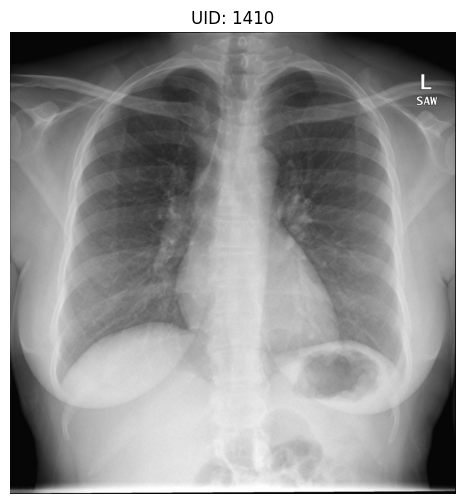

--------------------------------------------------
UID: 1410
Real Finding:
The heart size is normal. The mediastinal contour is within normal limits. The lungs are free of any focal infiltrates. There are no nodules or masses. No visible pneumothorax. No visible pleural fluid. The XXXX are grossly normal. There is no visible free intraperitoneal air under the diaphragm.
--------------------------------------------------
Predicted Report:
Findings:  XXXX sternotomy XXXX and mediastinal clips are stable. Stable cardiomediastinal silhouette. Stable right lower lobe calcified granuloma. Stable right lung calcified granuloma. Stable right lung calcified granuloma. Stable right lung calcified granuloma. Stable right lung calcified granuloma. Stable right lung calcified granuloma. Stable right lung calcified granuloma. Stable right lung calc
--------------------------------------------------
Evaluation Metrics:
BLEU-1: 0.1774
BLEU-2: 0.0171
BLEU-3: 0.0082
BLEU-4: 0.0054
ROUGE-L: 0.0400
------

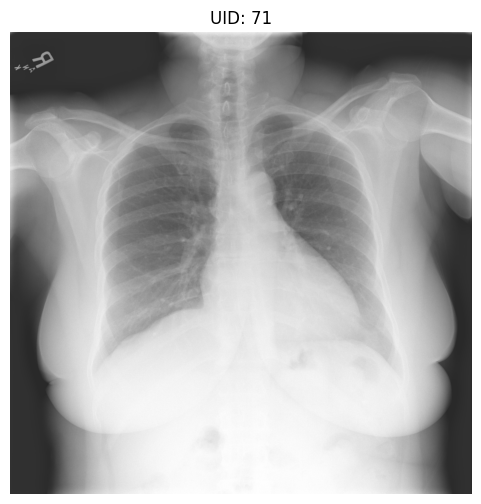

--------------------------------------------------
UID: 71
Real Finding:
The heart is upper limits of normal in size. The lungs are clear, without evidence of infiltrate. There is no pneumothorax or effusion.
--------------------------------------------------
Predicted Report:
Findings:  XXXX sternotomy XXXX and mediastinal clips are stable. There is no acute infiltrate or pleural effusion. The lungs are clear. There is no evidence of pneumothorax. Degenerative changes of the spine.
--------------------------------------------------
Evaluation Metrics:
BLEU-1: 0.4737
BLEU-2: 0.3394
BLEU-3: 0.2555
BLEU-4: 0.1924
ROUGE-L: 0.3273
--------------------------------------------------



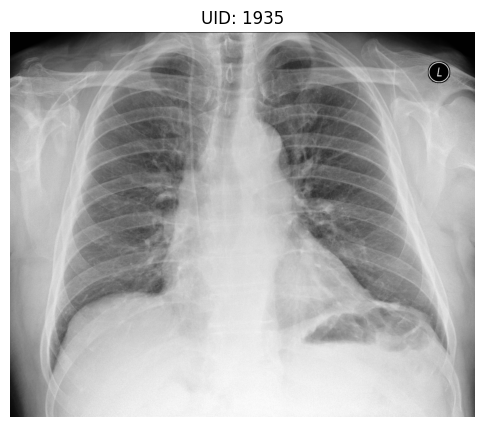

--------------------------------------------------
UID: 1935
Real Finding:
The heart is borderline in size. The aorta is mildly tortuous. XXXX right IJ catheter is in XXXX with tip in proximal right atrium/cavoatrial junction. There is no pneumothorax. Lungs are grossly clear. There is no large effusion.
--------------------------------------------------
Predicted Report:
Findings:  XXXX sternotomy XXXX and mediastinal clips are stable. The lungs are clear. There is no pleural effusion or pneumothorax. The heart is not significantly enlarged. There are atherosclerotic changes of the aorta. Arthritic changes of the skeletal structures are noted.
--------------------------------------------------
Evaluation Metrics:
BLEU-1: 0.4375
BLEU-2: 0.2894
BLEU-3: 0.1971
BLEU-4: 0.1341
ROUGE-L: 0.2250
--------------------------------------------------



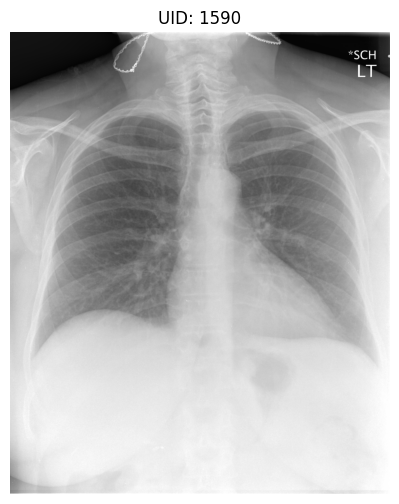

--------------------------------------------------
UID: 1590
Real Finding:
The lungs are clear bilaterally. Specifically, no evidence of focal consolidation, pneumothorax, or pleural effusion.. Cardio mediastinal silhouette is unremarkable. Visualized osseous structures of the thorax are without acute abnormality.
--------------------------------------------------
Predicted Report:
Findings:  XXXX sternotomy XXXX and mediastinal clips are stable. There is no pneumothorax or pleural effusion. The heart is not significantly enlarged. There are atherosclerotic changes of the aorta. Arthritic changes of the skeletal structures are noted.
--------------------------------------------------
Evaluation Metrics:
BLEU-1: 0.3721
BLEU-2: 0.1331
BLEU-3: 0.0363
BLEU-4: 0.0181
ROUGE-L: 0.2985
--------------------------------------------------



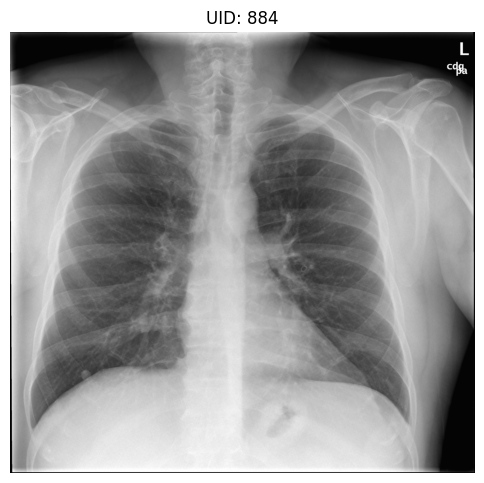

--------------------------------------------------
UID: 884
Real Finding:
The lungs are clear bilaterally. Specifically, no evidence of focal consolidation, pneumothorax, or pleural effusion.. Right basilar calcified granuloma noted. Cardio mediastinal silhouette is unremarkable. Visualized osseous structures of the thorax are without acute abnormality.
--------------------------------------------------
Predicted Report:
Findings:  XXXX sternotomy XXXX and mediastinal clips are stable. There is no acute infiltrate or pleural effusion. The lungs are clear. There is no focal consolidation. There are no XXXX of pleural effusion. There is no evidence of pneumothorax.
--------------------------------------------------
Evaluation Metrics:
BLEU-1: 0.4565
BLEU-2: 0.2665
BLEU-3: 0.1722
BLEU-4: 0.1030
ROUGE-L: 0.2973
--------------------------------------------------



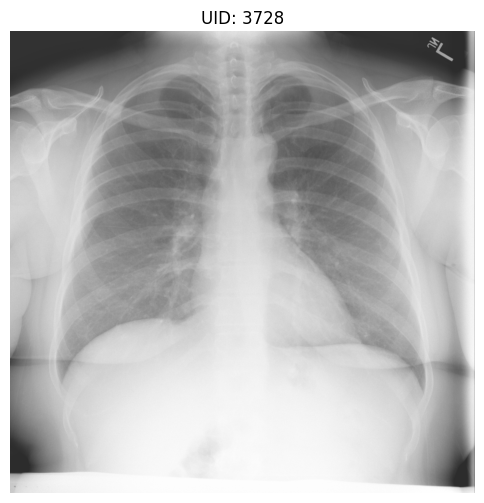

--------------------------------------------------
UID: 3728
Real Finding:
The XXXX examination consists of frontal and lateral radiographs of the chest. The cardiomediastinal contours are within normal limits. No focal consolidation, pleural effusion, or pneumothorax identified. The visualized osseous structures and upper abdomen are unremarkable.
--------------------------------------------------
Predicted Report:
Findings:  XXXX sternotomy XXXX and mediastinal clips are stable. Stable cardiomediastinal silhouette. Stable right lower lobe calcified granuloma. Stable right lung calcified granuloma. Stable right lung calcified granuloma. Stable right lung calcified granuloma. Stable right lung calcified granuloma. Stable right lung calcified granuloma. Stable right lung calcified granuloma. Stable right lung calc
--------------------------------------------------
Evaluation Metrics:
BLEU-1: 0.1290
BLEU-2: 0.0145
BLEU-3: 0.0074
BLEU-4: 0.0049
ROUGE-L: 0.0682
----------------------------

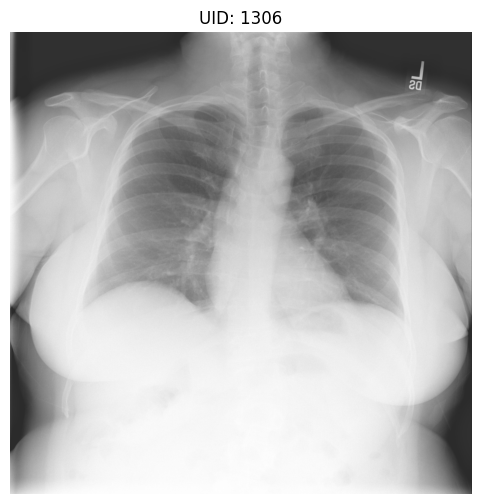

--------------------------------------------------
UID: 1306
Real Finding:
The XXXX examination consists of frontal and lateral radiographs of the chest. There are diminished lung volumes. The cardiomediastinal contours are within normal limits. Pulmonary vascularity is within normal limits. No focal consolidation, pleural effusion, or pneumothorax identified. XXXX scoliosis is unchanged. Visualized upper abdomen is grossly unremarkable.
--------------------------------------------------
Predicted Report:
Findings:  XXXX sternotomy XXXX and mediastinal clips are stable. There is no acute infiltrate or pleural effusion. The lungs are clear. There is no evidence of pneumothorax. Degenerative changes of the spine.
--------------------------------------------------
Evaluation Metrics:
BLEU-1: 0.3352
BLEU-2: 0.1483
BLEU-3: 0.0343
BLEU-4: 0.0159
ROUGE-L: 0.2000
--------------------------------------------------



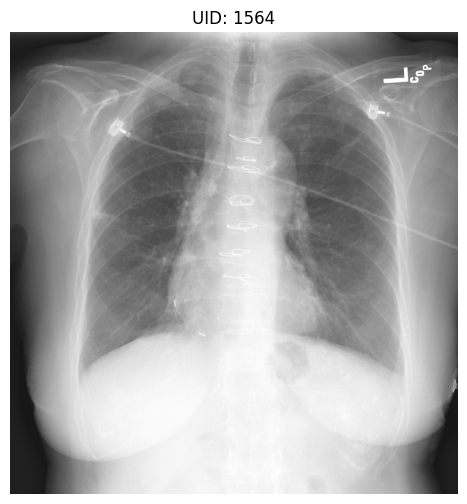

--------------------------------------------------
UID: 1564
Real Finding:
Heart size within normal limits, stable mediastinal and hilar contours, coronary artery stent artifact, XXXX XXXX and clips suggest CABG. Mediastinal and hilar calcifications XXXX indicate a previous granulomatous process. Stable hyperinflation, bilateral upper lobe pleuroparenchymal near and nodular irregularities, right greater than left, XXXX opacities in the peripheral right lung most compatible with scarring. No XXXX abnormal pulmonary opacities, no definite pleural effusion seen. No typical findings of pulmonary edema. Osseous demineralization, stable appearance of T9 and T12 XXXX fractures.
--------------------------------------------------
Predicted Report:
Findings:  XXXX sternotomy XXXX and mediastinal clips are stable. There is no acute infiltrate or pleural effusion. The lungs are clear. There is no evidence of pneumothorax. The visualized bony structures reveal no acute abnormalities.
--------------

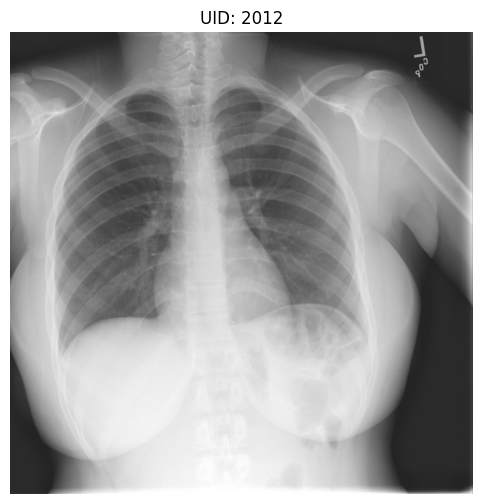

--------------------------------------------------
UID: 2012
Real Finding:
Normal cardiomediastinal contours. Lungs are clear bilaterally. No pneumothorax or pleural effusion.
--------------------------------------------------
Predicted Report:
Findings:  XXXX sternotomy XXXX and mediastinal clips are stable. Stable cardiomediastinal silhouette. Stable right lower lobe calcified granuloma. Stable right lung calcified granuloma. Stable right lung calcified granuloma. Stable right lung calcified granuloma. Stable right lung calcified granuloma. Stable right lung calcified granuloma. Stable right lung calcified granuloma. Stable right lung calc
--------------------------------------------------
Evaluation Metrics:
BLEU-1: 0.0806
BLEU-2: 0.0115
BLEU-3: 0.0064
BLEU-4: 0.0044
ROUGE-L: 0.0625
--------------------------------------------------



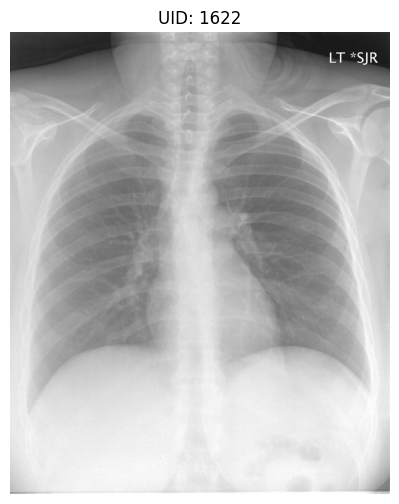

--------------------------------------------------
UID: 1622
Real Finding:
The cardiomediastinal silhouette is within normal limits for size and contour. The lungs are normally inflated without evidence of focal airspace disease, pleural effusion, or pneumothorax. No acute osseus abnormality..
--------------------------------------------------
Predicted Report:
Findings:  XXXX sternotomy XXXX and mediastinal clips are stable. There is no acute infiltrate or pleural effusion. The lungs are clear. There is no evidence of pneumothorax. The visualized bony structures reveal no acute abnormalities.
--------------------------------------------------
Evaluation Metrics:
BLEU-1: 0.3659
BLEU-2: 0.2343
BLEU-3: 0.1440
BLEU-4: 0.0928
ROUGE-L: 0.3077
--------------------------------------------------



In [ ]:
import os
import random
import torch
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.tokenize import word_tokenize
from rouge_score import rouge_scorer
from transformers import ViTImageProcessor, ViTModel, GPT2LMHeadModel, GPT2Tokenizer

# ---------------------------
# Model and Tokenizer Loading
# ---------------------------
MODEL_SAVE_PATH = "/kaggle/working/Vit_GPT2_IUXray"  # Folder where models were saved

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load GPT-2 tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained(os.path.join(MODEL_SAVE_PATH, "ViT_gpt2_tokenizer"))
tokenizer.pad_token = tokenizer.eos_token
gpt2_model = GPT2LMHeadModel.from_pretrained(os.path.join(MODEL_SAVE_PATH, "ViT_gpt2")).to(device)
gpt2_model.eval()

# Load ViT model from pretrained weights and then load saved state
vit_model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k").to(device)
vit_model.load_state_dict(torch.load(os.path.join(MODEL_SAVE_PATH, "ViT_model.pth"), map_location=device))
vit_model.eval()

# Define and load CrossAttention module
import torch.nn as nn
class CrossAttention(nn.Module):
    def __init__(self, embed_dim=768, num_heads=8):
        super(CrossAttention, self).__init__()
        self.multihead_attn = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.norm = nn.LayerNorm(embed_dim)
    def forward(self, img_features, text_embeds):
        attn_output, _ = self.multihead_attn(text_embeds, img_features, img_features)
        return self.norm(attn_output + text_embeds)

cross_attention = CrossAttention(embed_dim=768).to(device)
cross_attention.load_state_dict(torch.load(os.path.join(MODEL_SAVE_PATH, "CrossAttention.pth"), map_location=device))
cross_attention.eval()

# Load ViT feature extractor
vit_processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

# ---------------------------
# Load DataFrames (Reports and Projections)
# ---------------------------
# Load Indiana University reports
reports_df = pd.read_csv("/kaggle/input/chest-xrays-indiana-university/indiana_reports.csv")
reports_df = reports_df.dropna(subset=["findings"]).set_index("uid")

# Load projections which contain image filenames and projection type
projections_df = pd.read_csv("/kaggle/input/chest-xrays-indiana-university/indiana_projections.csv")
projections_df = projections_df.set_index("uid")

# Compute common UIDs between reports and projections
common_uids = set(reports_df.index).intersection(set(projections_df.index))
print("Common UIDs:", common_uids)

# ---------------------------
# Define Utility Functions
# ---------------------------
def process_xray(image_path):
    """Load and preprocess an image."""
    image = Image.open(image_path).convert("RGB")
    img_tensor = vit_processor(images=image, return_tensors="pt")["pixel_values"].to(device)
    return img_tensor

def generate_report(image_path, max_length=100):
    """Generate a report from the image using ViT, GPT-2, and CrossAttention."""
    img_tensor = process_xray(image_path)
    with torch.no_grad():
        # Extract image features from ViT and average over patches
        vit_outputs = vit_model(pixel_values=img_tensor)
        img_embed = vit_outputs.last_hidden_state.mean(dim=1).unsqueeze(1)  # shape: (1, 1, hidden_dim)

    # Initialize prompt
    input_tokens = tokenizer.encode("Findings: ", return_tensors="pt").to(device)

    for _ in range(max_length):
        with torch.no_grad():
            tok_embed = gpt2_model.get_input_embeddings()(input_tokens)
            fused_embeds = cross_attention(img_embed.expand(-1, tok_embed.shape[1], -1), tok_embed)
            outputs = gpt2_model(inputs_embeds=fused_embeds)
            next_token = torch.argmax(outputs.logits[:, -1, :], dim=-1).unsqueeze(0)
            if next_token.item() == tokenizer.eos_token_id:
                break
            input_tokens = torch.cat([input_tokens, next_token], dim=1)

    predicted_report = tokenizer.decode(input_tokens[0], skip_special_tokens=True)
    return predicted_report

# ---------------------------
# Inference for 10 Random UIDs
# ---------------------------
# Select 10 random UIDs from common_uids
sample_uids = random.sample(list(common_uids), 10)

smooth_fn = SmoothingFunction().method1

for uid in sample_uids:
    # Retrieve one image for the uid from projections_df (choose the first image)
    proj_entry = projections_df.loc[uid]
    if isinstance(proj_entry, pd.DataFrame):
        image_name = proj_entry.iloc[0]["filename"]
    else:
        image_name = proj_entry["filename"]

    # Build full image path
    image_path = os.path.join("/kaggle/input/chest-xrays-indiana-university/images/images_normalized", image_name)

    # Retrieve real finding
    if uid in reports_df.index:
        real_finding = reports_df.loc[uid]["findings"]
    else:
        real_finding = "Real finding not available."

    # Generate predicted report
    predicted_report = generate_report(image_path, max_length=100)

    # Compute evaluation metrics
    ref_tokens = [word_tokenize(real_finding)]
    pred_tokens = word_tokenize(predicted_report)

    bleu1 = sentence_bleu(ref_tokens, pred_tokens, weights=(1, 0, 0, 0), smoothing_function=smooth_fn)
    bleu2 = sentence_bleu(ref_tokens, pred_tokens, weights=(0.5, 0.5, 0, 0), smoothing_function=smooth_fn)
    bleu3 = sentence_bleu(ref_tokens, pred_tokens, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smooth_fn)
    bleu4 = sentence_bleu(ref_tokens, pred_tokens, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth_fn)

    rouge = rouge_scorer.RougeScorer(["rougeL"], use_stemmer=True)
    rouge_score = rouge.score(predicted_report, real_finding)["rougeL"].fmeasure

    # Display the image
    image = Image.open(image_path).convert("RGB")
    plt.figure(figsize=(6,6))
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"UID: {uid}")
    plt.show()

    # Print results and metrics
    print("--------------------------------------------------")
    print(f"UID: {uid}")
    print("Real Finding:")
    print(real_finding)
    print("--------------------------------------------------")
    print("Predicted Report:")
    print(predicted_report)
    print("--------------------------------------------------")
    print("Evaluation Metrics:")
    print(f"BLEU-1: {bleu1:.4f}")
    print(f"BLEU-2: {bleu2:.4f}")
    print(f"BLEU-3: {bleu3:.4f}")
    print(f"BLEU-4: {bleu4:.4f}")
    print(f"ROUGE-L: {rouge_score:.4f}")
    print("--------------------------------------------------\n")


### Encoder: **Swin Transformer** + Decoder: **GPT-2**

In [ ]:
uids = projections_df.uid.unique()
train_uids, test_uids = train_test_split(uids, test_size=0.1, random_state=42)
vision_model = create_model('swin_base_patch4_window7_224', pretrained=True)
vision_model.head = nn.Identity()
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
lang_model = GPT2LMHeadModel.from_pretrained('gpt2')

In [ ]:
class CrossAttention(nn.Module):
    def __init__(self, embed_dim, num_heads=8):
        super(CrossAttention, self).__init__()
        self.multihead_attn = nn.MultiheadAttention(embed_dim, num_heads)

    def forward(self, img_features, text_embeds):
        img_features = img_features.permute(1, 0, 2)
        text_embeds = text_embeds.permute(1, 0, 2)
        attn_output, _ = self.multihead_attn(text_embeds, img_features, img_features)
        return attn_output.permute(1, 0, 2)

cross_attention = CrossAttention(768)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vision_model = vision_model.to(device)
lang_model = lang_model.to(device)
cross_attention = cross_attention.to(device)

vision_model.eval()
for param in vision_model.parameters():
    param.requires_grad = False

rouge = rouge_scorer.RougeScorer(["rougeL"], use_stemmer=True)

class ImageCaptionData(Dataset):
    def __init__(self, reports_df, projections_df, max_length=128, max_img_stack=6):
        self.reports_df = reports_df.dropna(subset={'findings'}).set_index('uid')
        self.projections_df = projections_df.set_index('uid')
        self.uids = list(set(self.reports_df.index).intersection(self.projections_df.index))
        self.max_length = max_length
        self.max_img_stack = max_img_stack

    def __getitem__(self, index):
        uid = self.uids[index]
        image_paths = [os.path.join(img_base_dir, x) for x in list(self.projections_df.loc[[uid]]['filename'])]
        images = torch.stack([
            torch.tensor(np.array(Image.open(img).convert('RGB').resize((224, 224))))
            for img in image_paths
        ])

        len_image_stack = len(images)
        img_dim = images[0].shape
        images = torch.cat((torch.zeros((self.max_img_stack - len_image_stack, *img_dim)), images), dim=0)

        findings = tokenizer.encode(self.reports_df.loc[uid]['findings'])
        findings = torch.tensor(findings[:self.max_length-1] + [tokenizer.eos_token_id])

        return len_image_stack, images, findings

    def __len__(self):
        return len(self.uids)

def collate_batch(batch):
    len_images = torch.tensor([item[0] for item in batch])
    img_data = torch.stack([item[1] for item in batch])
    pad_id = tokenizer.pad_token_id if tokenizer.pad_token_id else tokenizer.eos_token_id
    tokens = pad_sequence([item[2] for item in batch], batch_first=True, padding_value=pad_id)
    labels = pad_sequence([item[2] for item in batch], batch_first=True, padding_value=pad_id)
    attn = (tokens != pad_id).long()
    return len_images, img_data, tokens, labels, attn



In [ ]:
train_dataset = ImageCaptionData(reports_df[reports_df.uid.isin(train_uids)], projections_df[projections_df.uid.isin(train_uids)])
test_dataset = ImageCaptionData(reports_df[~reports_df.uid.isin(train_uids)], projections_df[~projections_df.uid.isin(train_uids)])
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=collate_batch)

# **تعریف بهینه‌ساز**
optimizer = torch.optim.Adam([
    {"params": lang_model.parameters(), "lr": 2e-5},
    {"params": cross_attention.parameters(), "lr": 5e-5}
])


In [ ]:
NUM_EPOCHS = 5
best_val_loss = float("inf")

for epoch in range(NUM_EPOCHS):
    lang_model.train()
    cross_attention.train()
    train_loss = []

    for _, img, tokens, labels, attn in tqdm.tqdm(train_dataloader, desc=f"Training Epoch {epoch+1}"):
        img, tokens, labels, attn = img.to(device), tokens.to(device), labels.to(device), attn.to(device)
        optimizer.zero_grad()

        img = img.view(-1, 3, 224, 224)
        img_features = vision_model(img).view(tokens.shape[0], -1, 768)
        tok_embed = lang_model.get_input_embeddings()(tokens)
        attn_output = cross_attention(img_features, tok_embed)
        input_embed = attn_output + tok_embed

        outputs = lang_model(inputs_embeds=input_embed, labels=labels, attention_mask=attn)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())

    avg_train_loss = np.mean(train_loss)
    print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}")

    lang_model.eval()
    cross_attention.eval()
    val_loss, bleu_scores, rouge_scores = [], [], []

    with torch.no_grad():
        for _, img, tokens, labels, attn in tqdm.tqdm(test_dataloader, desc="Validating"):
            img, tokens, labels, attn = img.to(device), tokens.to(device), labels.to(device), attn.to(device)

            img = img.view(-1, 3, 224, 224)
            img_features = vision_model(img).view(tokens.shape[0], -1, 768)  # (batch_size, num_patches, embed_dim)

            tok_embed = lang_model.get_input_embeddings()(tokens)
            attn_output = cross_attention(img_features, tok_embed)
            input_embed = attn_output + tok_embed

            if attn.dim() == 3:
                attn = attn.squeeze(1)

            outputs = lang_model(inputs_embeds=input_embed, labels=labels, attention_mask=attn)
            loss = outputs.loss
            val_loss.append(loss.item())

            pred_ids = torch.argmax(outputs.logits, dim=-1)
            pred_text = tokenizer.decode(pred_ids[0], skip_special_tokens=True)

            true_labels = labels[0].cpu().numpy()
            true_labels = true_labels[true_labels != -100]
            true_text = tokenizer.decode(true_labels.tolist(), skip_special_tokens=True)

            bleu_scores.append(sentence_bleu([true_text.split()], pred_text.split()))
            rouge_scores.append(rouge.score(pred_text, true_text)["rougeL"].fmeasure)

    avg_val_loss = np.mean(val_loss)
    print(f"BLEU Score: {np.mean(bleu_scores):.4f} | ROUGE-L: {np.mean(rouge_scores):.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        MODEL_SAVE_PATH = "/kaggle/working/Swin_model"
        os.makedirs(MODEL_SAVE_PATH, exist_ok=True)
        lang_model.save_pretrained(os.path.join(MODEL_SAVE_PATH, 'Swin_gpt-2-model'))
        tokenizer.save_pretrained(os.path.join(MODEL_SAVE_PATH, 'Swin_gpt-2-tokenizer'))
        torch.save(vision_model.state_dict(), os.path.join(MODEL_SAVE_PATH, 'Swin_model.pth'))
        torch.save(cross_attention.state_dict(), os.path.join(MODEL_SAVE_PATH, 'Swin_cross_attention.pth'))
        print(f" {MODEL_SAVE_PATH} ")


Training Epoch 1:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 1: Train Loss = 1.4045


Validating:   0%|          | 0/84 [00:00<?, ?it/s]

BLEU Score: 0.3195 | ROUGE-L: 0.5743
 /kaggle/working/Swin_model 


Training Epoch 2:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 2: Train Loss = 0.9736


Validating:   0%|          | 0/84 [00:00<?, ?it/s]

BLEU Score: 0.3725 | ROUGE-L: 0.6371
 /kaggle/working/Swin_model 


Training Epoch 3:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 3: Train Loss = 0.8603


Validating:   0%|          | 0/84 [00:00<?, ?it/s]

BLEU Score: 0.4041 | ROUGE-L: 0.6540
 /kaggle/working/Swin_model 


Training Epoch 4:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 4: Train Loss = 0.7907


Validating:   0%|          | 0/84 [00:00<?, ?it/s]

BLEU Score: 0.4307 | ROUGE-L: 0.6656
 /kaggle/working/Swin_model 


Training Epoch 5:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 5: Train Loss = 0.7385


Validating:   0%|          | 0/84 [00:00<?, ?it/s]

BLEU Score: 0.4540 | ROUGE-L: 0.6811
 /kaggle/working/Swin_model 


In [ ]:
MODEL_PATH = "/kaggle/working/Swin_model"

lang_model = GPT2LMHeadModel.from_pretrained(os.path.join(MODEL_PATH, 'Swin_gpt-2-model'))
tokenizer = GPT2Tokenizer.from_pretrained(os.path.join(MODEL_PATH, 'Swin_gpt-2-tokenizer'))

vision_model = timm.create_model('swin_base_patch4_window7_224', pretrained=False, num_classes=0)
vision_model.load_state_dict(torch.load(os.path.join(MODEL_PATH, 'Swin_model.pth')))
vision_model.eval()

class CrossAttention(torch.nn.Module):
    def __init__(self, embed_dim, num_heads=8):
        super(CrossAttention, self).__init__()
        self.multihead_attn = torch.nn.MultiheadAttention(embed_dim, num_heads)

    def forward(self, img_features, text_embeds):
        img_features = img_features.permute(1, 0, 2)
        text_embeds = text_embeds.permute(1, 0, 2)
        attn_output, _ = self.multihead_attn(text_embeds, img_features, img_features)
        return attn_output.permute(1, 0, 2)

cross_attention = CrossAttention(768)
cross_attention.load_state_dict(torch.load(os.path.join(MODEL_PATH, 'Swin_cross_attention.pth')))
cross_attention.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lang_model = lang_model.to(device)
vision_model = vision_model.to(device)
cross_attention = cross_attention.to(device)


In [ ]:
def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB').resize((224, 224))
    image = torch.tensor(np.array(image)).permute(2, 0, 1).unsqueeze(0).float().to(device)
    image = image / 255.0
    return image


In [ ]:
def generate_report(image_path):
    lang_model.eval()
    cross_attention.eval()

    image = preprocess_image(image_path)

    with torch.no_grad():
        img_features = vision_model.forward_features(image)

    batch_size, embed_dim, height, width = img_features.shape
    num_patches = height * width

    img_features = img_features.permute(0, 2, 3, 1).reshape(batch_size, num_patches, embed_dim)

    # print(f"Final img_features shape: {img_features.shape}")

    projection_layer = nn.Linear(embed_dim, 768).to(device)
    img_features = projection_layer(img_features)

    # print(f"Projected img_features shape: {img_features.shape}")

    tokens = torch.tensor([tokenizer.bos_token_id]).unsqueeze(0).to(device)
    generated = []

    for _ in range(128):
        tok_embed = lang_model.get_input_embeddings()(tokens)

        seq_length = tok_embed.shape[1]
        if img_features.shape[1] < seq_length:
            img_features = img_features.repeat(1, seq_length // img_features.shape[1], 1)
        elif img_features.shape[1] > seq_length:
            img_features = img_features[:, :seq_length, :]

        # print(f"Updated img_features shape: {img_features.shape}")

        attn_output = cross_attention(img_features, tok_embed)
        input_embed = attn_output + tok_embed

        outputs = lang_model(inputs_embeds=input_embed)
        next_token = torch.argmax(outputs.logits[:, -1, :], dim=-1)

        tokens = torch.cat([tokens, next_token.unsqueeze(0)], dim=-1)
        generated.append(next_token.item())

        if next_token == tokenizer.eos_token_id:
            break

    return tokenizer.decode(generated, skip_special_tokens=True)


In [ ]:
image_path = "/kaggle/input/chest-xrays-indiana-university/images/images_normalized/1013_IM-0013-1001.dcm.png"

report = generate_report(image_path)
print(f"Findings: {report}")


Findings:  heart size and mediastinal contours are within normal limits. No focal airspace consolidation, pleural effusion, or pneumothorax. No acute bony abnormalities. Osseous structures are grossly intact.
